# 1. DESCARGA Y EDA

In [52]:
from datasets import load_dataset
import pandas as pd
import nltk
import numpy as np
import matplotlib as plt
import multiprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, TreebankWordTokenizer, RegexpTokenizer
from nltk import ngrams
from nltk.probability import FreqDist
from collections import Counter
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from time import time



In [4]:
# Cargar el dataset
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

# Verificar las particiones disponibles
print(dataset)


DatasetDict({
    full: Dataset({
        features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
        num_rows: 701528
    })
})


In [5]:
#descargamos un tokenizador de frases

nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CARLES\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Convertir la partición 'full' a un DataFrame de pandas
df = pd.DataFrame(dataset['full'])

# Seleccionar sólo las columnas 'text' y 'rating' y las renombramos para usar los mismos nombres que en clase
df = df[['text', 'rating']]
df.rename(columns={'text': 'review', 'rating': 'sentiment'}, inplace=True)

# Eliminar filas con valores NaN en las columnas 'text' y 'rating'
df.dropna(subset=['review', 'sentiment'], inplace=True)

# Resetear los índices del DataFrame
df.reset_index(drop=True, inplace=True)

# Mostrar el DataFrame
print(df)

                                                   review  sentiment
0       This spray is really nice. It smells really go...        5.0
1       This product does what I need it to do, I just...        4.0
2                               Smells good, feels great!        5.0
3                                          Felt synthetic        1.0
4                                                 Love it        5.0
...                                                   ...        ...
701523    Conditioner is great  shampoo not as I expected        4.0
701524  Did not work! Used the whole bottle and my hai...        1.0
701525         Product as expected. Shipping was on time.        5.0
701526  Not only is it a delicious fragrance, but also...        5.0
701527  The conditioner doesn't really make your hair ...        4.0

[701528 rows x 2 columns]


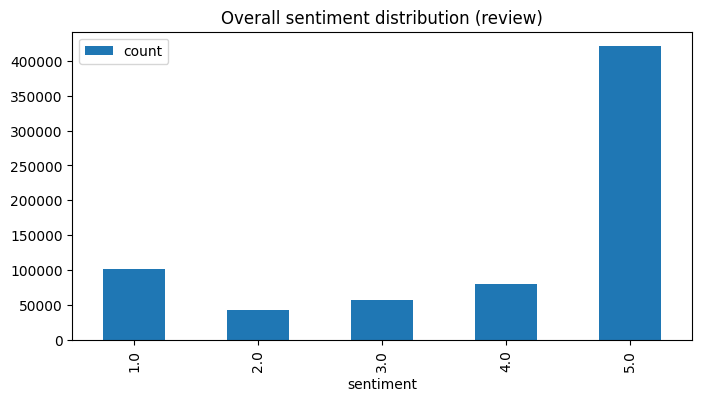

In [7]:
aux_df = pd.DataFrame(df['sentiment'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

Vemos que tenemos muchos registros en general.
Para trabajar con menos registros y viendo la distribución de los datos, vamos a eliminar registros donde el sentiment sea 5

In [8]:
max_5_sentiment = 200000

# Filtrar los registros donde el rating es 1, 2, 3 o 4
filtered_df = df[df['sentiment'].isin([1, 2, 3, 4])]

# Seleccionar aleatoriamente 20,000 registros donde el rating es 5
rating_5_sample = df[df['sentiment'] == 5].sample(n=max_5_sentiment, random_state=42)

# Combinar ambos subconjuntos
reduced_df = pd.concat([filtered_df, rating_5_sample])

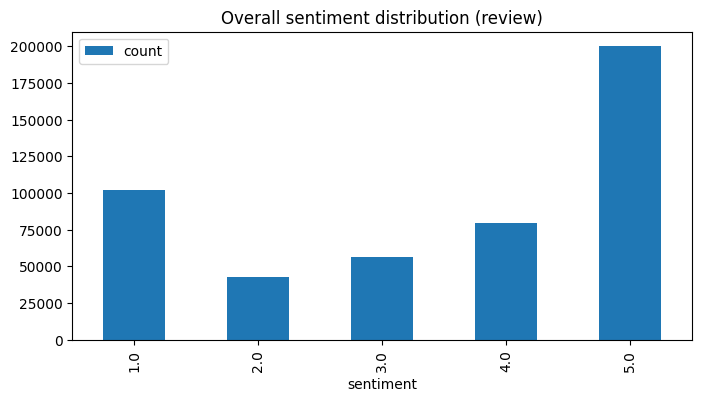

In [9]:
aux_df = pd.DataFrame(reduced_df['sentiment'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

In [10]:
# Asegúrate de que todos los elementos en la columna 'review' son cadenas de texto
reduced_df['review'] = reduced_df['review'].astype(str)

# Tokenizar cada revisión en oraciones
reduced_df['sentences'] = reduced_df['review'].apply(lambda x: sent_tokenize(x))

# Inicializar una lista para almacenar las palabras
words = []

# Inicializar el tokenizer
tokenizer = TreebankWordTokenizer()

# Iterar sobre cada lista de oraciones tokenizadas
for sentence_list in reduced_df['sentences']:
    for sentence in sentence_list:
        tokens = tokenizer.tokenize(sentence)
        for idx, word in enumerate(tokens):
            # Ignorar palabras que sean espacios en blanco
            if not word.isspace():
                words.append(word)

In [11]:
words

['This',
 'product',
 'does',
 'what',
 'I',
 'need',
 'it',
 'to',
 'do',
 ',',
 'I',
 'just',
 'wish',
 'it',
 'was',
 'odorless',
 'or',
 'had',
 'a',
 'soft',
 'coconut',
 'smell',
 '.',
 'Having',
 'my',
 'head',
 'smell',
 'like',
 'an',
 'orange',
 'coffee',
 'is',
 'offputting',
 '.',
 '(',
 'granted',
 ',',
 'I',
 'did',
 'know',
 'the',
 'smell',
 'was',
 'described',
 'but',
 'I',
 'was',
 'hoping',
 'it',
 'would',
 'be',
 'light',
 ')',
 'Felt',
 'synthetic',
 'The',
 'polish',
 'was',
 'quiet',
 'thick',
 'and',
 'did',
 'not',
 'apply',
 'smoothly',
 '.',
 'I',
 'let',
 'dry',
 'overnight',
 'before',
 'adding',
 'a',
 'second',
 'coat',
 'since',
 'it',
 'was',
 'so',
 'thick',
 '.',
 'These',
 'were',
 'lightweight',
 'and',
 'soft',
 'but',
 'much',
 'too',
 'small',
 'for',
 'my',
 'liking',
 '.',
 'I',
 'would',
 'have',
 'preferred',
 'two',
 'of',
 'these',
 'together',
 'to',
 'make',
 'one',
 'loc',
 '.',
 'For',
 'that',
 'reason',
 'I',
 'will',
 'not',
 'be',

In [61]:
# Guardamos
df.to_csv(r'C:\Users\CARLES\1.CARLES\FORMACIONES\BOOTCAMP KEEPCODING\10. NLP\df_nlp.csv', index = False)
reduced_df.to_csv(r'C:\Users\CARLES\1.CARLES\FORMACIONES\BOOTCAMP KEEPCODING\10. NLP\reduced_df_nlp.csv', index = False)

# Convertimos las words en un df y guardamos
words_df = pd.DataFrame(words, columns=['word'])
words_df.to_csv(r'C:\Users\CARLES\1.CARLES\FORMACIONES\BOOTCAMP KEEPCODING\10. NLP\words_nlp.csv', index = False)

Cardinalidad del vocabulario del df reducido


In [12]:
cardinalidad = len(words)
print(f'Cardinalidad del vocabulario: {cardinalidad}')

Cardinalidad del vocabulario: 18817464


Nº de reviews positivas y negativas

In [13]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 1
    else:
        return 0

In [14]:
reduced_df['is_negative_sentiment'] = reduced_df.apply(lambda row: label_sentiment(row), axis=1)
reduced_df.head

<bound method NDFrame.head of                                                    review  sentiment  \
1       This product does what I need it to do, I just...        4.0   
3                                          Felt synthetic        1.0   
5       The polish was quiet thick and did not apply s...        4.0   
7       These were lightweight and soft but much too s...        3.0   
10      I was very disappointed when I got this facial...        3.0   
...                                                   ...        ...   
595353  I enjoy it for praying over people and anointi...        5.0   
564545                          It’s exactly as depicted!        5.0   
247022  Works well, so much better than putting foil o...        5.0   
334751  I really enjoyed these masks. They felt calmin...        5.0   
412137  A little goes a long way. It then washes off y...        5.0   

                                                sentences  \
1       [This product does what I need it to

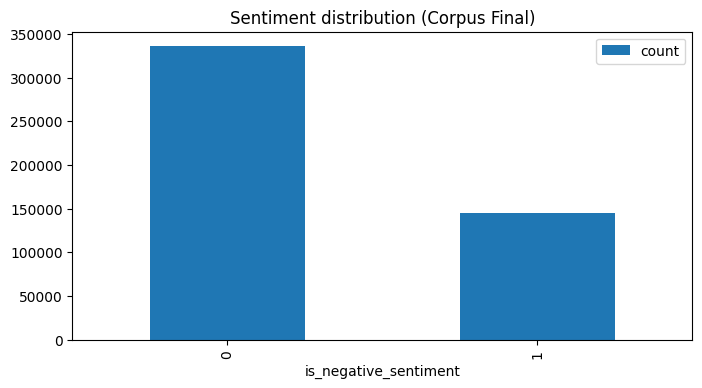

In [15]:
aux_df = pd.DataFrame(reduced_df['is_negative_sentiment'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

N-grams más frecuentes

In [19]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [21]:
bigrams_freq_.most_common(10)

[(('.', 'I'), 218811),
 (('<', 'br'), 108586),
 (('br', '/'), 108586),
 (('/', '>'), 108586),
 (('.', 'It'), 79343),
 (('.', 'The'), 78264),
 ((',', 'but'), 55763),
 (('!', '!'), 54039),
 (('I', 'have'), 51677),
 (('of', 'the'), 45023)]

In [22]:
trigrams_freq_.most_common(10)

[(('<', 'br', '/'), 108586),
 (('br', '/', '>'), 108586),
 (('>', '<', 'br'), 33779),
 (('/', '>', '<'), 33775),
 (('!', '!', '!'), 22547),
 (('.', 'I', 'have'), 20667),
 (('/', '>', 'I'), 13196),
 (('.', 'It', "'s"), 12857),
 (('.', 'This', 'is'), 12095),
 (('.', 'I', 'love'), 11878)]

Nubes de palabras

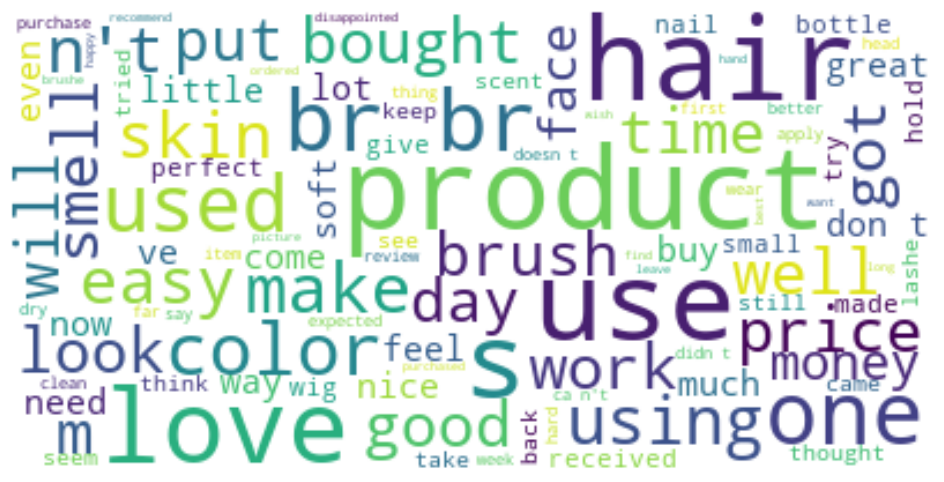

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Ejemplo de uso
plot_word_cloud(words)



Visualización en 2 dimensiones de algunos word embeddings calculados con
Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)

In [40]:
cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

16


In [57]:
# Hyperparameters e Inicializamos los objetos Word2Vec
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [47]:
# Construimos el vocabulario
t = time()
sent = [row.split() for row in reduced_df['review']]
w2v_model.build_vocab(sent, progress_per=10000)

print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))

Tiempo para construir el vocabulario: 0.13 mins
Vocabulario compuesto por 21323 palabras


In [48]:
# Entrenamos el modelo
t = time()

w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 3.12 mins


In [49]:
# Guardamos los modelos
w2v_model.save('./w2v_model.pkl')

In [51]:
# Creamos clusters de palabras con las más similares a unas dadas
keys = ['product','price','hair','color','smell']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

print(word_clusters)

[['product,', 'item', 'product.', 'serum', 'Product', 'stuff', 'cream', 'products', 'product!', 'product.<br'], ['price,', 'price.', 'Price', 'cost,', 'price!', 'pricing', 'cost', 'priced', 'quality', 'value'], ['hair,', 'hair.', 'hair!', 'hair.<br', 'curly', 'curls', 'hair-', 'Hair', 'frizzy', 'hair...'], ['color,', 'color.', 'shade', 'colors', 'colour', 'Color', 'color-', 'brown', 'shade,', 'brown)'], ['scent', 'smell,', 'smells', 'smell.', 'scent,', 'fragrance', 'smelled', 'smelling', 'Smells', 'taste']]


In [53]:
# Reducimos la dimensionalidad para poder representar
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

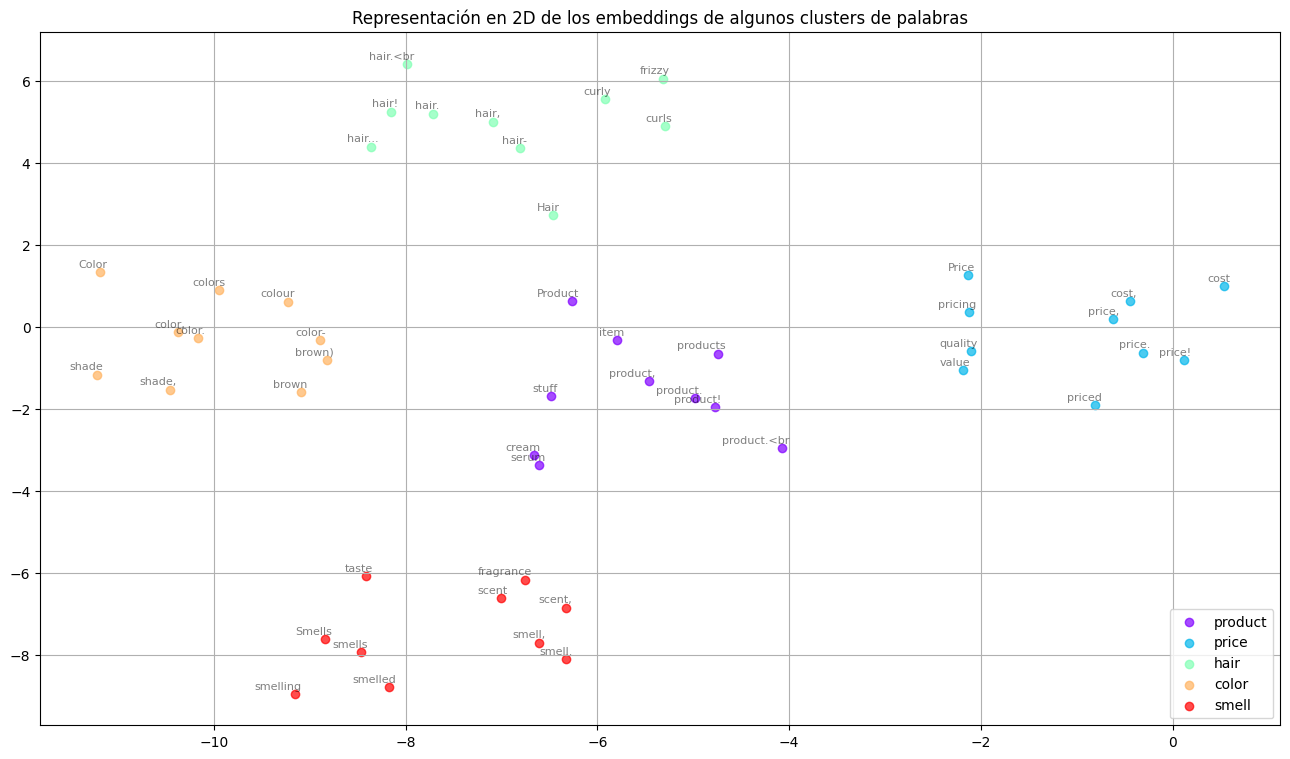

In [54]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

keys = ['product','price','hair','color','smell']

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

In [ ]:


words.to_csv(r'C:\Users\CARLES\1.CARLES\FORMACIONES\BOOTCAMP KEEPCODING\10. NLP', )


# CONCLUSIONES

El corpus elegido es bastante extenso, lo cual los tiempos para analizarlos son elevados. Por ello, gracias a visualizar la distribucion de la variable sentiment, hemos decidio coger menos valores donde el sentiment = 5.

También hemos visto que por lo general, el producto es bueno ya que hay mayor número de valoraciones positivas que negativas.

Por último, destacar que hacer el ejercicio de visualizar palabras similares a las seleccionadas suele ser muy valioso pero no lo vemos relevante hacerlo en este punto, ya que al no haber hecho un procesamiento de los datos, no nos han aparecido muchos sinónimos sino la misma palabra pero con puntos, comas o otros signos. Creemos que aportaria mucho valor hacerlo una vez hubiésemos procesado los datos.